In [1]:
import polars as pl
import polars.selectors as cs

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree

import matplotlib.pyplot as plt
# import pickle

from modules.utils import data_utils, plot_utils

In [2]:
data = data_utils.load_data()

# Multioutput regression

- In this analysis, our goal is to recommend content for SEDDS formulations. 
- The predictions are based on the characteristics of the drug and the desired characteristics of excipients.

- The model can still be improved with training information about whether this content is ideal for further development of such SEDDS formulations. (and possibly add new data into dataset if possible)

In [3]:
multi_target = ['oil_total', 'other_total', 'surfactant_total', 'cosolvent_total', 'API_prop']

- We assume that the following features are not known to the user before actually creating a SEDDS formulation. We are removing information about the number of distinct excipients used as well.

In [4]:
inputs_unavailable = ['progressed', 'PDI', 'cplx_minmax_norm', 'size', 'o_num', 's_num', 'c_num', 'other_num']

### Models

- We will define the following models to see how well they perform on the data.


In [5]:
reg_models = {
    'dt': Pipeline([
        ('fillna', SimpleImputer(strategy="median")),
        ('dt', DecisionTreeRegressor(max_depth = 3, random_state=42))
    ]),
    'rf': Pipeline([
        ('fillna', SimpleImputer(strategy="median")),
        ('sc', StandardScaler()), 
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
}

In [6]:
X = data.drop(multi_target + inputs_unavailable).to_pandas()
y = data[multi_target].drop_nulls().to_pandas()

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
reg_dt = reg_models.get('dt')
reg_rf_multioutput = reg_models.get('rf')


In [8]:
reg_dt.fit(X_tr, y_tr)
reg_rf_multioutput.fit(X_tr, y_tr)

Pipeline(steps=[('fillna', SimpleImputer(strategy='median')),
                ('sc', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [9]:
reg_dt.score(X_ts, y_ts), 

(0.30817827431475964,)

In [10]:
reg_rf_multioutput.score(X_ts, y_ts)

0.6631399170534497

- Random Forest chose as a model for further analysis. Other are not performing that well.

In [11]:
X_tr.columns

Index(['API_mol_wt', 'logp_chemaxon', 'API_melt_temp', 'API_water_sol',
       'API_polar_sa', 'API_rot_bond', 'API_H_bond_donor', 'API_H_bond_accept',
       'o_LC', 'o_sat', 's_HLB', 'c_mol_wt', 'c_melt_temp', 'c_boil_temp',
       'c_density', 'c_viscosity'],
      dtype='object')

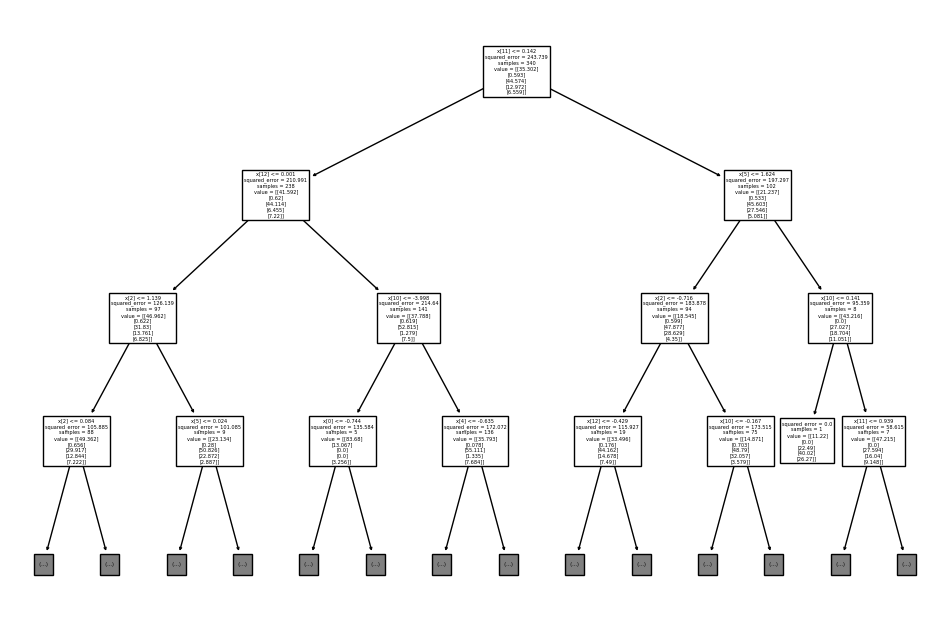

In [12]:
plt.figure(figsize=(12, 8))  # Increase the plot size for better visibility
tree.plot_tree(reg_rf_multioutput.named_steps['rf'].estimators_[0], max_depth=3)  # Limit tree depth for simplicity
plt.show()


- molecular weight of cosolvent
    - then spliting for its melting temperature and number of drug bond acceptors 
        - then drug melting temperature and weight-averaged hydrophilic-lipophilic balance of surfactants in the formulation

In [13]:
X_tr.iloc[:, 11]


235      0.000000
399     76.099998
602    134.199997
61       0.000000
145     76.099998
          ...    
71      46.099998
106    134.199997
270      0.000000
435     46.099998
102    134.199997
Name: c_mol_wt, Length: 534, dtype: float32

In [14]:
X_tr.iloc[:, 12]

235      0.000000
399    -59.000000
602    -76.000000
61       0.000000
145    -59.000000
          ...    
71    -114.099998
106    -76.000000
270      0.000000
435   -114.099998
102    -76.000000
Name: c_melt_temp, Length: 534, dtype: float32

In [15]:
X_tr.iloc[:, 7]

235     6.0
399    12.0
602     3.0
61      2.0
145     5.0
       ... 
71      2.0
106     2.0
270     3.0
435    10.0
102     2.0
Name: API_H_bond_accept, Length: 534, dtype: float32

In [16]:
X_tr.iloc[:, 10]

235    14.4
399    15.0
602    15.0
61     15.0
145    15.0
       ... 
71     15.0
106    13.0
270    15.0
435    14.5
102    13.0
Name: s_HLB, Length: 534, dtype: float32

In [17]:
X_tr.iloc[:, 2]

235    116.5
399    149.5
602    136.5
61     225.5
145    125.5
       ...  
71     137.0
106    225.5
270     80.5
435    216.5
102    225.5
Name: API_melt_temp, Length: 534, dtype: float32

## Feature engineering

- **thermal_stability_index**
    - single metric that captures thermal properties of the cosolvent
    - cosolvent toleration to temperatures?
- **chemical_stability_index**
    - possible stability against chemical reactions?

In [18]:
# NOTE: commented out features did not improve the model
# data_f = data.with_columns(
#     ((pl.col('c_melt_temp') * pl.col('c_boil_temp')).alias('thermal_stability_index'))
# )

# data_f = data_f.with_columns(
#     (pl.col('c_density') * pl.col('c_viscosity')).alias('chemical_stability_index')
# )

- **API_molwt_c_density_interaction**
    - Indicator for the solubility and stability of the drug with the cosolvent. 
    - Higher value than might suggest more soluble formulation?
- **melt_sol_polar_ratio**
    - Higher ratio might suggest more thermally stable/soluble formulation?

In [19]:
data_f = data.with_columns([
    (pl.col('API_water_sol') * pl.col('API_mol_wt') * pl.col('c_density') * pl.col('c_mol_wt')).alias('API_molwt_c_density_interaction'), # 0.67
    (pl.col('API_melt_temp') * pl.col('API_water_sol') / pl.col('API_polar_sa')).alias('melt_sol_polar_ratio') # 0.6674
    # (pl.col('s_HLB') * pl.col('c_density')).alias('f') # 0.6674
    # (pl.col('API_polar_sa') * pl.col('s_HLB')).alias('API_polarsa_s_HLB_interaction'),
    # pl.col('s_HLB').pow(2).alias('s_HLB_squared'),
])

In [20]:
data_f.describe()

statistic,progressed,size,PDI,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,cplx_minmax_norm,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept,o_LC,o_sat,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity,API_molwt_c_density_interaction,melt_sol_polar_ratio
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""668""",506.0,289.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,"""668""","""668""",668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0
"""null_count""","""0""",162.0,379.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,140.205658,0.250784,6.415936,35.014633,45.269371,12.147912,1.152695,1.368263,1.288922,0.646707,0.091317,0.174401,481.722534,4.733294,130.891464,0.057113,95.349953,8.296407,1.73503,4.547904,null,null,13.642815,78.044014,-42.598801,97.270958,0.582036,13.658234,962.202148,0.839492
"""std""",null,304.983734,0.146898,6.055097,21.0464,20.49094,15.289106,6.349833,0.560316,0.625828,0.551164,0.308378,0.109052,229.726608,1.685694,48.424789,0.175672,74.825226,3.715382,1.995535,3.195637,null,null,2.526405,105.660721,47.233089,92.058823,0.472266,27.431568,3786.706299,3.2521
"""min""",null,7.2,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.289993,-2.3,59.5,0.00011,6.48,0.0,0.0,2.0,null,null,0.0,0.0,-114.099998,0.0,0.0,0.0,0.0,0.000642
"""25%""",null,31.9,0.145,2.0,18.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0,0.125,360.829987,3.64,80.5,0.00071,46.529999,6.0,0.0,3.0,null,null,13.0,0.0,-76.0,0.0,0.0,0.0,0.0,0.001087
"""50%""",null,76.529999,0.23,5.0,33.169998,44.0,8.0,0.0,1.0,1.0,1.0,0.0,0.125,406.473999,5.22,125.5,0.0122,52.599998,7.0,1.0,3.0,null,null,14.5,46.099998,-26.0,78.400002,0.8,1.1,19.496004,0.014151
"""75%""",null,170.699997,0.32,8.5,50.34,61.5,19.34,0.0,2.0,2.0,1.0,0.0,0.25,500.423004,5.28,149.5,0.0234,117.68,11.0,2.0,6.0,null,null,15.0,134.199997,0.0,202.0,1.0,4.8,554.912964,0.024325
"""max""",null,4964.0,0.949,52.700001,99.32,97.0,76.800003,68.040001,3.0,5.0,3.0,2.0,1.0,1202.609985,8.06,232.0,0.75,319.609985,18.0,12.0,17.0,null,null,16.9,600.0,32.5,261.200012,1.2,90.0,59699.265625,13.715278


- After several experiments API_molwt_c_density_interaction and melt_sol_polar_ratio slightly improved model R2.

In [21]:
selected_features = ['melt_sol_polar_ratio', 'API_molwt_c_density_interaction']

In [22]:
X = data_f.drop(multi_target + inputs_unavailable).to_pandas()
y = data_f[multi_target].drop_nulls().to_pandas()

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
reg_rf_multioutput.fit(X_tr, y_tr)
reg_rf_multioutput.score(X_ts, y_ts)

0.6731515716176449

In [24]:
# reg_rf_multioutput.fit(X, y)

#### Save the best model

We will save the best performing model to a file for future use.

In [25]:
# pickle.dump(reg_rf_multioutput, open('../../models/multi_output_model.pkl', 'wb'))